# Example CLIP model

*This notebook is still experimental and I have not tested yet to fine-tune a `CLIP` model on `COCO`. I will try to test it further for the next update ;)*

In [1]:
import os
import glob
import logging
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from utils import normalize_filename, plot, plot_matrix, plot_multiple, plot_classification
from loggers import set_level, timer
from datasets import get_dataset
from models.siamese import CLIP
from utils.image import _image_formats, display_image, load_image, draw_boxes

time_logger = logging.getLogger('timer')

pretrained = 'RN50x4'
model_name = 'clip_' + pretrained.lower()

print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.6.2


In [2]:
model = CLIP(
    nom  = model_name,
    lang = 'en',
    input_size   = 224 if pretrained == 'RN50' else 288,
    text_encoder = 'clip',
    pretrained   = pretrained,
    normalize = True
)

When using token / word-level tokenizer, it can be useful to add 'detach_punctuation' in cleaners
Model restoration...
Initializing submodel : `comparator` !
Successfully restored comparator from pretrained_models/clip_rn50x4/saving/comparator.json !
Model clip_rn50x4 initialized successfully !


## Model initialization

In [2]:
model = CLIP(nom = model_name)
print(model)

When using token / word-level tokenizer, it can be useful to add 'detach_punctuation' in cleaners
Model restoration...
Initializing submodel : `comparator` !
Successfully restored comparator from pretrained_models/clip_rn50x4/saving/comparator.json !
Model clip_rn50x4 initialized successfully !

========== clip_rn50x4 ==========
Sub model comparator
- Inputs 	: [(None, 288, 288, 3), [(None, None), (None,)]]
- Outputs 	: (None, 1)
- Number of layers 	: 6
- Number of parameters 	: 178.410 Millions
- Model not compiled

Transfer-learning from : RN50x4
Already trained on 0 epochs (0 steps)

- Embedding dim   : 640
- Distance metric : dp
- Image size : (288, 288, 3)
- Resize config : {'method': 'bicubic', 'antialias': True}
- Normalization style : clip
- Language : en
- Vocabulary (size = 49408) : ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ...]



In [ ]:
ds = get_dataset('coco', modes = 'valid', one_line_per_caption = True)
print(ds.shape)

In [ ]:
ds.head()

## Search

### Search text matching image

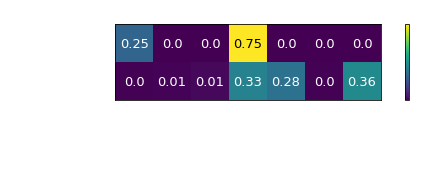

(2, 7)


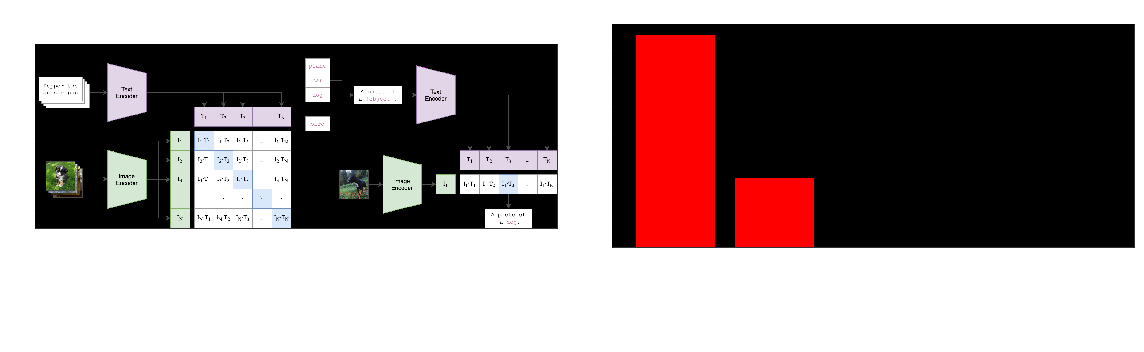

Text #0 (0.75) : a neural network
Text #0 (0.25) : a diagram
Text #0 (0.00) : a person
Text #0 (0.00) : a cat
Text #0 (0.00) : a dog
Text #0 (0.00) : a man
Text #0 (0.00) : a woman


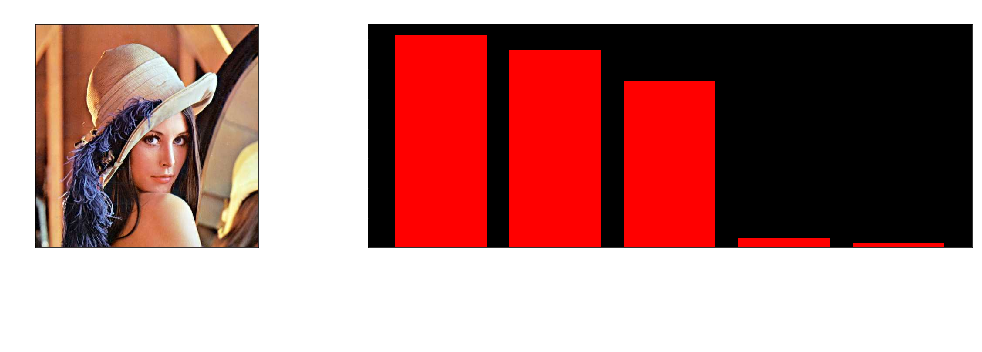

Text #1 (0.36) : a woman
Text #1 (0.33) : a neural network
Text #1 (0.28) : a person
Text #1 (0.01) : a cat
Text #1 (0.01) : a dog
Text #1 (0.00) : a diagram
Text #1 (0.00) : a man


In [3]:
from utils import download_file

filename = download_file('https://raw.github.com/openai/CLIP/main/CLIP.png')

texts    = ["a diagram", "a dog", "a cat", "a neural network", "a person", "a man", "a woman"]
images   = [filename, 'unitest/__datas/lena.jpg']

embed_img = model.embed_image(images)
embed_txt = model.embed_text(texts)

matrix = model.distance(embed_img, embed_txt, pred_matrix = True, pred_probability = True)
plot_matrix(matrix.numpy(), x_labels = texts, y_labels = images, xtick_rotation = 45, factor_size = 1.2)

print(matrix.shape)

for i, image in enumerate(images):
    plot_multiple(
        image = load_image(image),
        scores = {'scores' : matrix[i], 'labels' : texts, 'plot_type' : 'classification'},
        use_subplots = True, y_size = 5, x_size = 8
    )
    for idx in np.flip(tf.argsort(matrix[i])):
        text, score = texts[idx], matrix[i, idx]
        print('Text #{} ({:.2f}) : {}'.format(i, score, text))

### Search image matching text

In [4]:
from utils import normalize_filename

img_dir = ''

images = normalize_filename(img_dir)

images = [im for im in images if im.endswith(_image_formats)]

embed_img = model.embed_image(images)
print('Embedding shape : {}'.format(embed_img.shape))

Embedding shape : (901, 1024)


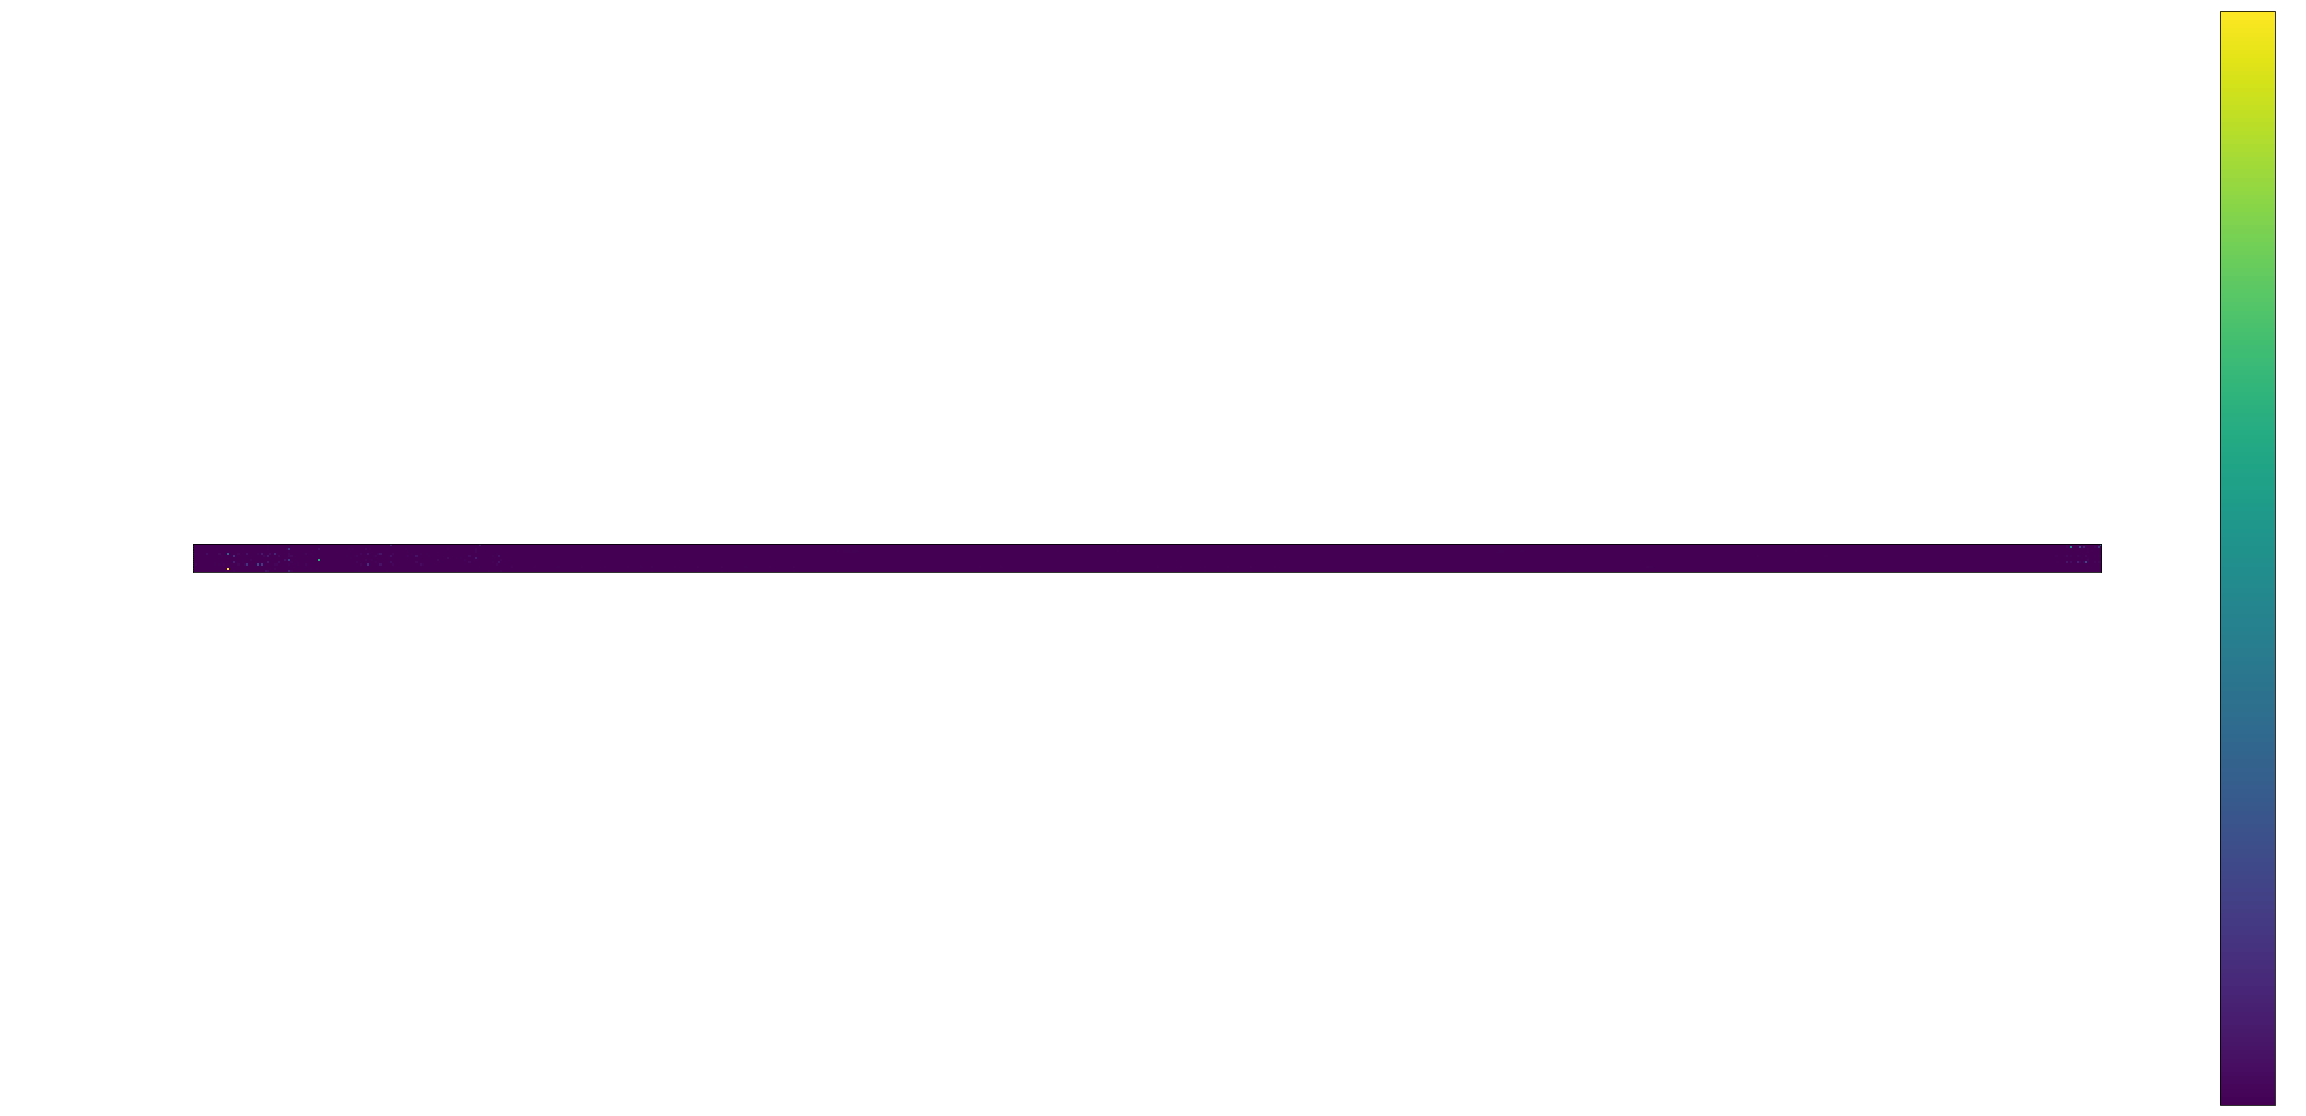

(13, 901)
a picture of a young manga girl


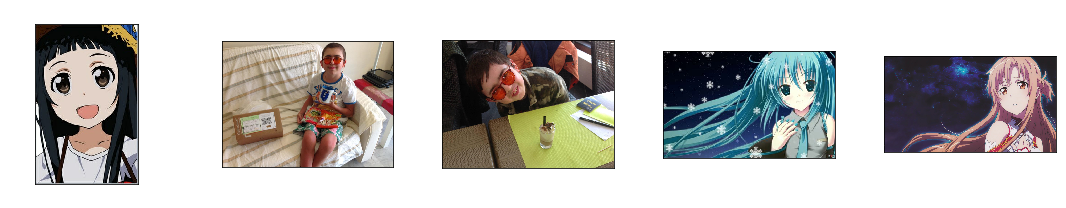

a girl with a sword


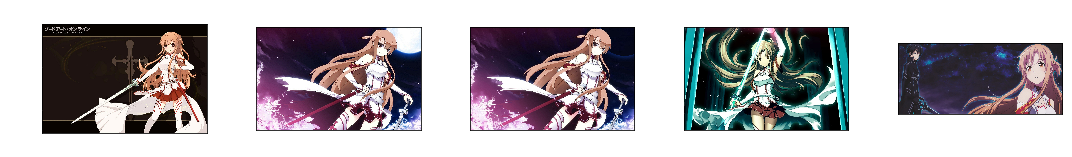

two person


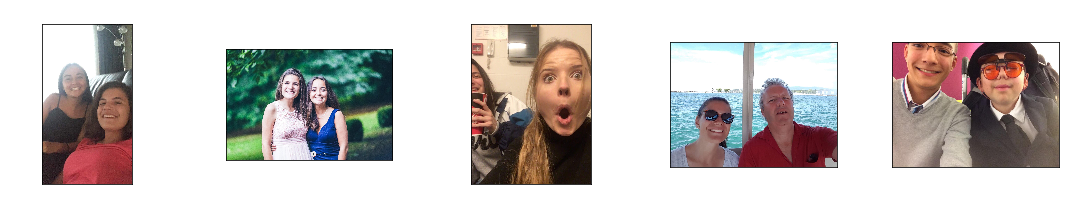

two manga person


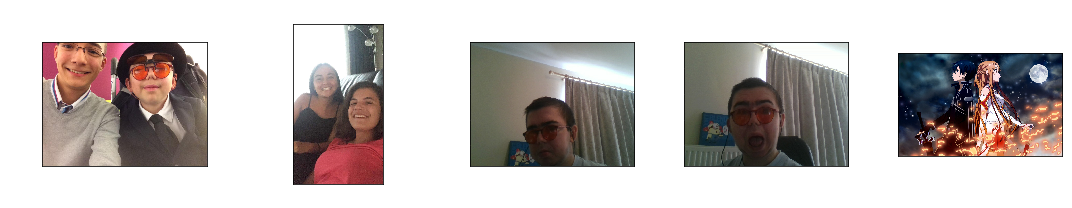

a photo of a group of people


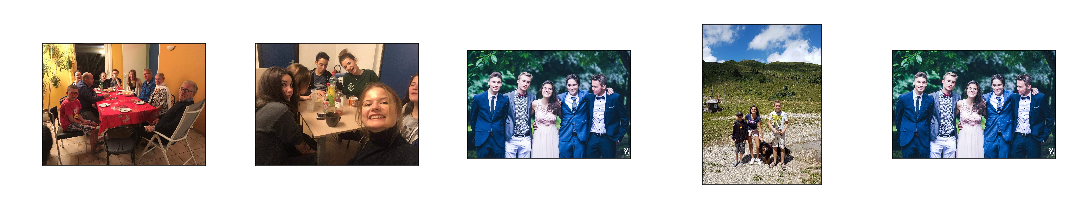

a picture of a girl with rose robe


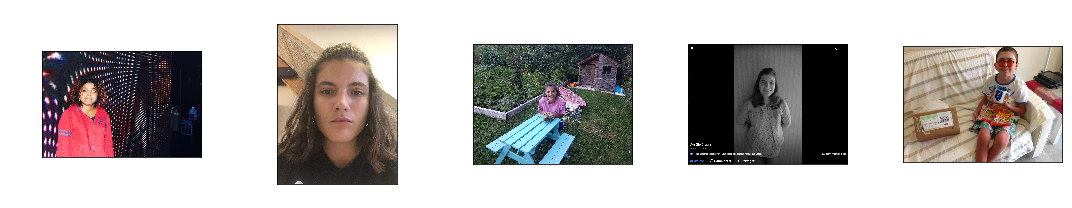

two man


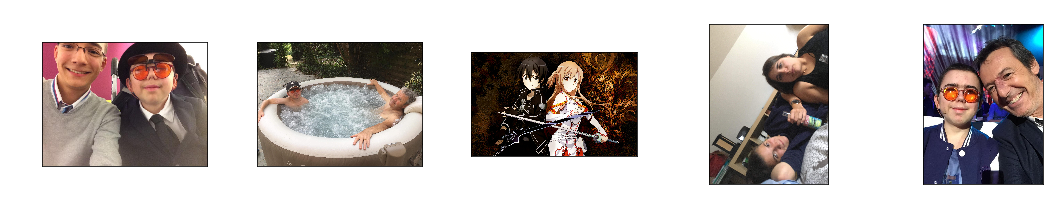

two woman


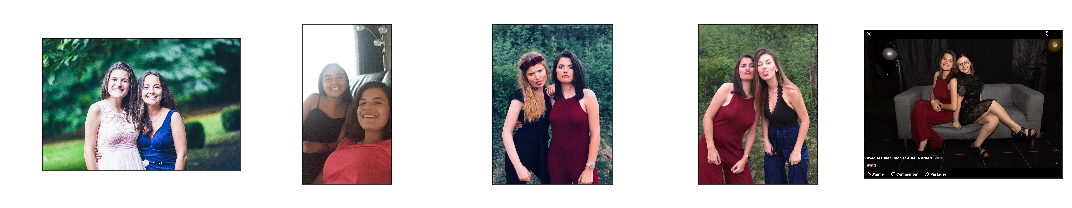

girl with long robe


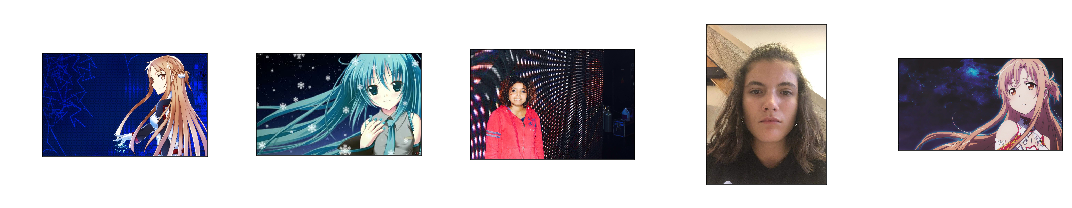

a group of 4 people


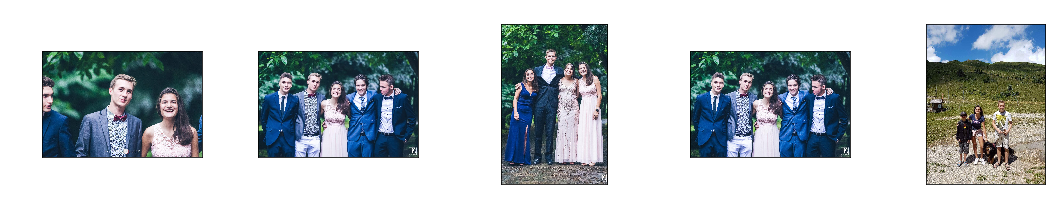

people with glasses


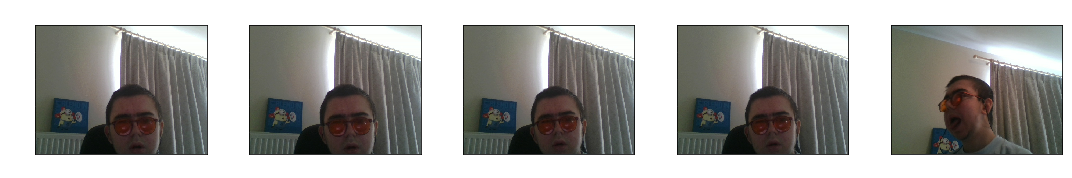

picture of people with table


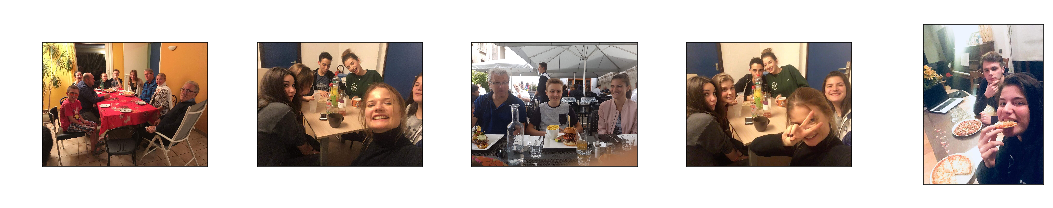

person in a sofa


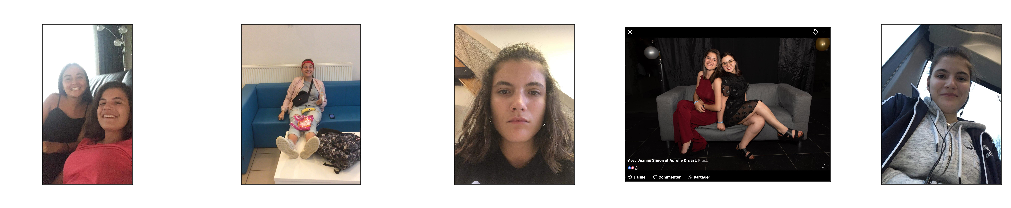

In [8]:
texts = []

embed_txt = model.embed_text(texts)

matrix = model.distance(embed_txt, embed_img, pred_matrix = True, pred_probability = True)
plot_matrix(matrix, y_labels = texts, xtick_rotation = 45, factor_size = 1.2)

print(matrix.shape)

for i, text in enumerate(texts):
    print(text)
    plot_multiple(** {
        '{:.4f}'.format(matrix[i,j]) : load_image(images[j])
        for j in np.flip(np.argsort(matrix[i]))[:5]
    }, plot_type = 'imshow', ncols = 5)


## Tests

In [4]:
from utils import pad_batch

class Test:
    @timer
    def embed(self, data, use_encoder_a, batch_size = 128, tqdm = lambda x: x, ** kwargs):
        """
            Embed a list of data
            
            Pipeline : 
                1) Call self.get_input(data) to have encoded data
                2) Take a batch of `batch_size` inputs
                3) Call pad_batch(batch) to have pad it (if necessary)
                4) Call self.preprocess_input(batch) to apply a preprocessing (if needed)
                5) Pass the processed batch to self.encoder
                6) Concat all produced embeddings to return [len(data), self.embedding_dim] matrix
            
            This function is the core of the `siamese networks` as embeddings are used for everything (predict similarity / distance), label predictions, clustering, make funny colored plots, ...
        """
        suffix = 'a' if use_encoder_a else 'b'
        
        time_logger.start_timer('processing')
        if not isinstance(data, (list, tuple, pd.DataFrame)): data = [data]
        
        inputs = getattr(self, 'get_input_{}'.format(suffix))(data, ** kwargs)

        time_logger.stop_timer('processing')
        
        encoder = getattr(self, 'encoder_{}'.format(suffix))
        
        embedded = []
        for idx in tqdm(range(0, len(inputs), batch_size)):
            time_logger.start_timer('processing')

            batch = inputs[idx : idx + batch_size]
            batch = pad_batch(batch) if not isinstance(batch[0], (list, tuple)) else [pad_batch(b) for b in zip(* batch)]
            batch = getattr(self, 'preprocess_input_{}'.format(suffix))(batch)
            
            time_logger.stop_timer('processing')
            time_logger.start_timer('encoding')

            embedded_batch = encoder(batch, training = False)
            if not isinstance(embedded_batch, tf.Tensor): embedded_batch = embedded_batch[0]
            
            time_logger.stop_timer('encoding')

            embedded.append(embedded_batch)

        return tf.concat(embedded, axis = 0)

set_level('time')

samples = ds.sample(25, random_state = 0)

embed_img = Test.embed(model, samples, use_encoder_a = True)
embed_txt = Test.embed(model, samples, use_encoder_a = False)


Timers for logger timer :
- embed : 3.379 sec
  - processing executed 2 times : 0.149 sec (0.075 sec / exec)
  - encoding : 3.229 sec
Timers for logger timer :
- embed : 0.186 sec
  - processing executed 2 times : 0.017 sec (0.009 sec / exec)
  - encoding : 0.169 sec
    - call : 0.168 sec
      - token embedding : 0.002 sec
        - embed_tokens : 0.001 sec
        - embed_token_types : 0.000 sec
        - embed_positions : 0.001 sec
      - call : 0.164 sec
        - layer call executed 12 times : 0.159 sec (0.013 sec / exec)


In [ ]:
from utils import download_file, plot_multiple, plot_confusion_matrix
from utils.distance import distance


matrix = model.distance(embed_img, embed_txt, pred_matrix = True)
plot_confusion_matrix(matrix.numpy(), plot_type = 'imshow', with_colorbar = True, norm = False)

for i, ((idx, row), emb1, emb2) in enumerate(zip(samples.iterrows(), embed_img, embed_txt)):
    print(row['text'])
    print(matrix[i,i])
    plot_multiple(** {
        '{:.4f}'.format(matrix[i,j]) : load_image(samples.iloc[j]['filename'])
        for j in np.flip(np.argsort(matrix[i]))[:5]
    }, plot_type = 'imshow', ncols = 5)


several cows grazing in a grassy  open field.


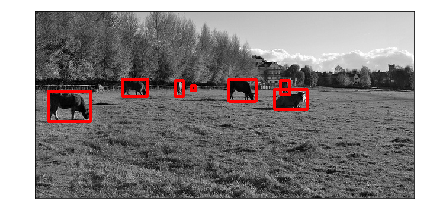

A wood paneled kitchen with dining table and tiled floor.


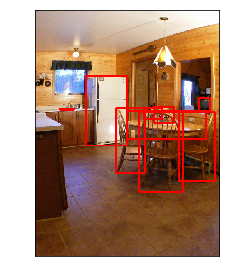

A cat looks up at the stove and is reflected in the oven's glass. 


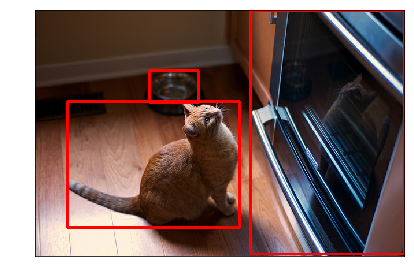

A fire hydrant with frozen water coming out of it.


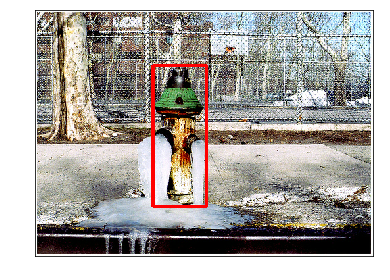

a herd of cows graze lazily by the pond


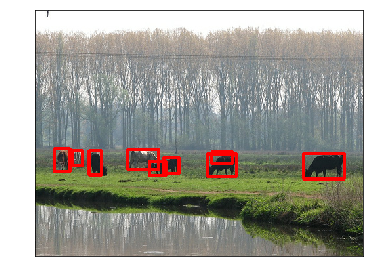

In [17]:
from utils import plot
from utils.image import *

for _, row in ds.sample(5, random_state = 0).iterrows():
    print(row['text'])
    plot(draw_boxes(row['filename'], row['box']))
    #display_image(row['filename'])

In [14]:
help(draw_boxes)

Help on function draw_boxes in module utils.image.box_utils:

draw_boxes(filename, boxes, shape=<Shape.RECT: 2>, color='r', thickness=3, use_label=False, labels=None, vertical=True, **kwargs)



In [15]:
ds

area  \
0      [702.1057499999998, 5463.686400000002, 10324.9...   
1      [702.1057499999998, 5463.686400000002, 10324.9...   
2      [702.1057499999998, 5463.686400000002, 10324.9...   
3      [702.1057499999998, 5463.686400000002, 10324.9...   
4      [702.1057499999998, 5463.686400000002, 10324.9...   
5      [27718.476299999995, 1440.6512500000006, 31322...   
6      [27718.476299999995, 1440.6512500000006, 31322...   
7      [27718.476299999995, 1440.6512500000006, 31322...   
8      [27718.476299999995, 1440.6512500000006, 31322...   
9      [27718.476299999995, 1440.6512500000006, 31322...   
10     [78969.31690000003, 55218.34945000001, 597.651...   
11     [78969.31690000003, 55218.34945000001, 597.651...   
12     [78969.31690000003, 55218.34945000001, 597.651...   
13     [78969.31690000003, 55218.34945000001, 597.651...   
14     [78969.31690000003, 55218.34945000001, 597.651...   
15                                  [108316.66515000002]   
16                                  [108316.66515000002]   
17                                  [108316.66515000002]   
18                                  [108316.66515000002]   
19                                  [108316.66515000002]   
20               [75864.53530000002, 31093.796150000006]   
21               [75864.53530000002, 31093.796150000006]   
22               [75864.53530000002, 31093.796150000006]   
23               [75864.53530000002, 31093.796150000006]   
24               [75864.53530000002, 31093.796150000006]   
25     [16932.135100000003, 18491.312100000003, 55.28...   
26     [16932.135100000003, 18491.312100000003, 55.28...   
27     [16932.135100000003, 18491.312100000003, 55.28...   
28     [16932.135100000003, 18491.312100000003, 55.28...   
29     [16932.135100000003, 18491.312100000003, 55.28...   
...                                                  ...   
24744                               [147597.04575000002]   
24745                               [147597.04575000002]   
24746                               [147597.04575000002]   
24747                               [147597.04575000002]   
24748                               [147597.04575000002]   
24749                                [84417.58910000001]   
24750                                [84417.58910000001]   
24751                                [84417.58910000001]   
24752                                [84417.58910000001]   
24753                                [84417.58910000001]   
24754  [10370.421600000001, 6240.972800000002, 6193.5...   
24755  [10370.421600000001, 6240.972800000002, 6193.5...   
24756  [10370.421600000001, 6240.972800000002, 6193.5...   
24757  [10370.421600000001, 6240.972800000002, 6193.5...   
24758  [10370.421600000001, 6240.972800000002, 6193.5...   
24759  [33402.40445, 41000.39229999999, 37623.5929999...   
24760  [33402.40445, 41000.39229999999, 37623.5929999...   
24761  [33402.40445, 41000.39229999999, 37623.5929999...   
24762  [33402.40445, 41000.39229999999, 37623.5929999...   
24763  [33402.40445, 41000.39229999999, 37623.5929999...   
24764                                       [29437.5762]   
24765                                       [29437.5762]   
24766                                       [29437.5762]   
24767                                       [29437.5762]   
24768                                       [29437.5762]   
24769                                        [46696.019]   
24770                                        [46696.019]   
24771                                        [46696.019]   
24772                                        [46696.019]   
24773                                        [46696.019]   

                                                     box  \
0      [[473, 395, 38, 28, dog], [204, 235, 60, 177, ...   
1      [[473, 395, 38, 28, dog], [204, 235, 60, 177, ...   
2      [[473, 395, 38, 28, dog], [204, 235, 60, 177, ...   
3      [[473, 395, 38, 28, dog], [204, 235, 60, 177, ...   
4      [[473, 395, 38, 28, dog]